# Acessing the course online:
[keeper including all data](https://keeper.mpdl.mpg.de/d/e779e0dc09724537b651/)



# Bayesian parameter estimation

- Today will be on Bayesian inference for the distance pdf from parallaxes (distance prior)
- Also inferring stellar parameters for our close encounters
- Building a forward model from a grid
- doing mcmc + forward model for AP inference
- correction of the RVS gravitational redshift
- calculating impact parameters
- what happens with extinction

Resources:
- [KDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html)
- [My PhD Thesis](https://arxiv.org/abs/1802.08432)
- [GDR2mock](https://arxiv.org/abs/1804.01427)
- [Geometric distances paper](https://arxiv.org/abs/1804.10121)
- [Distance Prior](https://arxiv.org/abs/1507.02105)
- [emcee](http://dfm.io/emcee/current/)

### Posterior: P(d|&varpi;,&sigma;<sub>&varpi;</sub>) = (Likelihood * Prior) / Evidence
### Likelihood: P(&varpi;|d,&sigma;<sub>&varpi;</sub>)
### Prior: P(d)
### Evidence: Integral of the Posterior over the parameterspace. We can neglect that for Parameter estimation.

#### Likelihood / measurement model
![Measurement model](pics/model.png)
The measurement model: 1AU/d = tan(&varpi;) = &varpi; 

d in pc, &varpi; in as (arcseconds)

---

![Likelihood](pics/likelihood.png)
The likelihood: a probability density function of the observed parallax &varpi;, conditioned on the true distance d.
![likelihoof](pics/likelihood_function.png)

---
![Priors](pics/Prior.png)
The Prior: a probability density funciton over the distance. Prior knowledge. Galaxy model? Let's have a look.

In [1]:
# For reproducability we will write out the versions of the libraries 
%load_ext version_information
%version_information numpy, matplotlib, astropy, scipy, healpy, emcee

Software versions
Python 3.6.3 64bit [GCC 7.2.0]
IPython 6.1.0
OS Linux 4.12.14 lp150.12.4 default x86_64 with glibc2.9
numpy 1.15.0
matplotlib 2.2.3
astropy 3.0.4
scipy 1.1.0
healpy 1.11.0
emcee 2.2.1
Thu Oct 11 00:18:15 2018 CEST

In [2]:
%pylab inline
import os
import sys
from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde
import emcee
from numpy.lib.recfunctions import append_fields
# Importing from own directory
from plotting import plot_hrd
from astropy.io import fits

Populating the interactive namespace from numpy and matplotlib


In order to get a Galaxy prior we queried again the GDR2mock catalog:
```SQL
SELECT COUNT(*) as ct, ROUND(1000/parallax,0) AS dist
FROM gdr2mock.main
WHERE phot_g_mean_mag < 12
GROUP BY dist
```
Which gives us the distance distribution of stars that are brighter than 12th G magnitude.

9874 ('ct', 'dist')


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


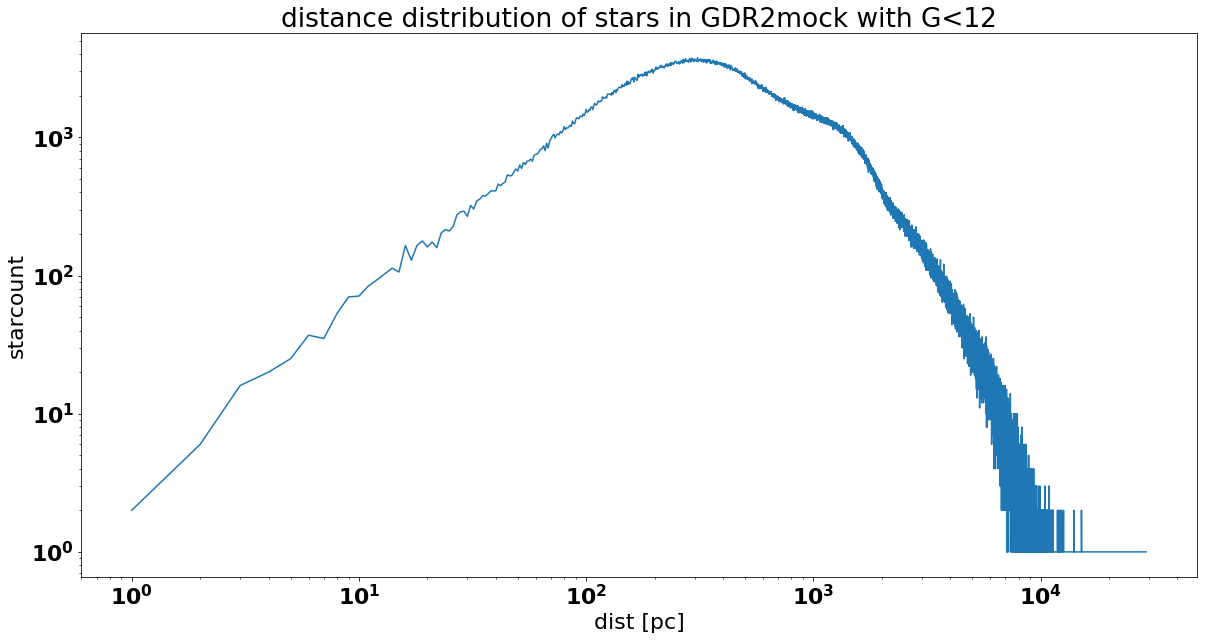

<Figure size 432x288 with 0 Axes>

In [3]:
prior = fits.getdata('../data/day_4/dist_prior_12g.fits')
print(len(prior),prior.dtype.names)
prior = prior.view(np.recarray)

# We use a bigger font for you to see better on the beamer
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(prior.dist,prior.ct)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('dist [pc]')
plt.ylabel('starcount')
plt.title('distance distribution of stars in GDR2mock with G<12')
plt.show()
plt.clf()

# TASK1
#### plot the posterior distribution of inferred distances for a star with: &varpi; = 10mas and &sigma;<sub>&varpi;</sub> = [0.01, 0.1, 1, 2, 3, 5] mas.
#### Hints:
- This time instead of sampling the uncertainty we will evaluate the function on a grid of distances
- use np.linspace() to create a distance grid (e.g. from 0 to 200 with 2001 steps) (a parallax of 10 --> distance of 100pc)
- evaluate the likelihood function on this grid. You can use the following function or write it yourself:
```python
def likelihood_function(distance,parallax,uncertainty):
    '''
    distance in pc
    parallax in mas
    uncertainty in mas
    
    returns unnormalized likelihood function
    '''
    parallax /= 1000
    uncertainty /= 1000
    result = np.exp(-np.divide((parallax-np.divide(1,distance))**2,2*uncertainty**2))
    return(result)
```
- interpolate the prior on this distance grid using np.interp() function
- just multiply the likelihood with the prior array and plot the result over the distances
- do this for the 3 different uncertainties

uncertainty:  0.5  fractional parallax uncertainty:  0.05
##############################################################################################


/home/rybizki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


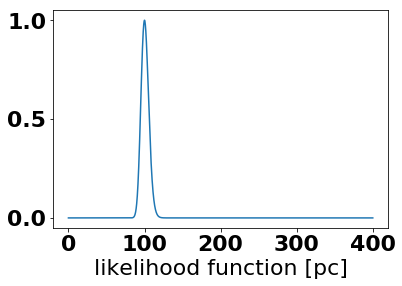

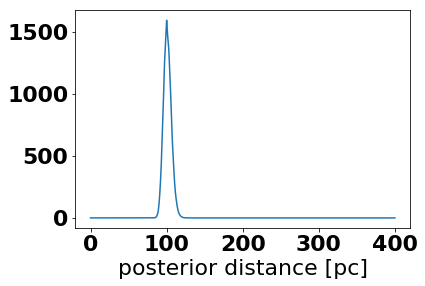

uncertainty:  1.5  fractional parallax uncertainty:  0.15
##############################################################################################


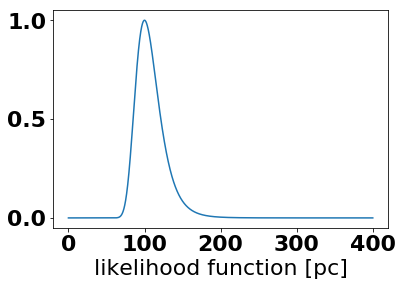

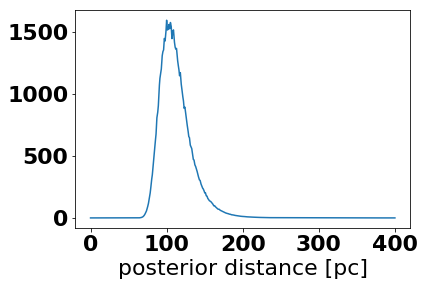

uncertainty:  4.5  fractional parallax uncertainty:  0.45
##############################################################################################


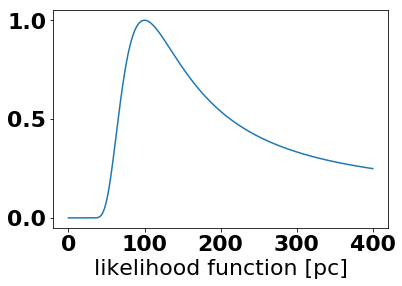

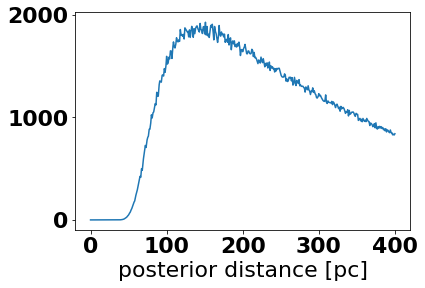

<Figure size 432x288 with 0 Axes>

In [4]:
def likelihood_function(distance,parallax,uncertainty):
    '''
    distance in pc
    parallax in mas
    uncertainty in mas
    
    returns unnormalized likelihood function
    '''
    parallax /= 1000
    uncertainty /= 1000
    result = np.exp(-np.divide((parallax-np.divide(1,distance))**2,2*uncertainty**2))
    return(result)

for sigma_varpi in [0.5,1.5,4.5]:
    measured_parallax = 10
    print('uncertainty: ', sigma_varpi, ' fractional parallax uncertainty: ', sigma_varpi/measured_parallax)
    print('##############################################################################################')
    dist_range = np.linspace(0,400,4001)

    likelihood = likelihood_function(dist_range,measured_parallax, sigma_varpi)
    plt.plot(dist_range,likelihood)
    plt.xlabel('likelihood function [pc]')
    plt.show()
    plt.clf()

    prior_dist = np.interp(dist_range,prior.dist,prior.ct,left = 0, right = 0)
    posterior = likelihood * prior_dist

    plt.plot(dist_range,posterior)
    plt.xlabel('posterior distance [pc]')
    plt.show()
    plt.clf()

What if we wanted to use a distance prior that depends on the position in the sky?

With the following ADQL query to the GAVO center:

```SQL
SELECT AVG(1000/parallax) AS mean_distance,
IVO_HEALPIX_INDEX(5, ra, dec) AS healpix
FROM gdr2mock.main
WHERE phot_g_mean_mag < 12
GROUP BY healpix
```

You get the mean distance per healpixel. That can be very easily displayed in topcat:
![mean distance over sky](pics/dist_over_sky.png)

Using this mean distance value per healpix in order to set the lengthscale of the distance prior for stars in that healpix is basically what we did for all stars in GDR2 with parallaxes in the [distance paper](https://arxiv.org/abs/1804.10121).

# Inferring stellar parameters

- Now we want to infer mass (m), age (&tau;) and metallicity (feh) of field stars from its position in the Hertzsprung-Russell diagram (HRD).
- For that we need a forward model, i.e. a function f(m,&tau;,feh) --> {M<sub>G</sub>, BP-RP}, which will serve as our measurement model
- And a Prior of m, &tau; and feh which we will get from GDR2mock

179620 ('mass', 'age', 'feh', 'a0', 'teff', 'logg', 'lum', 'gaia_g', 'gaia_bp', 'gaia_rp', 'ubv_u', 'ubv_b', 'ubv_v', 'ubv_r', 'ubv_i', 'ubv_j', 'ubv_h', 'ubv_k', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z', '2mass_j', '2mass_h', '2mass_ks', 'wise_w1', 'wise_w2', 'wise_w3', 'wise_w4')


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


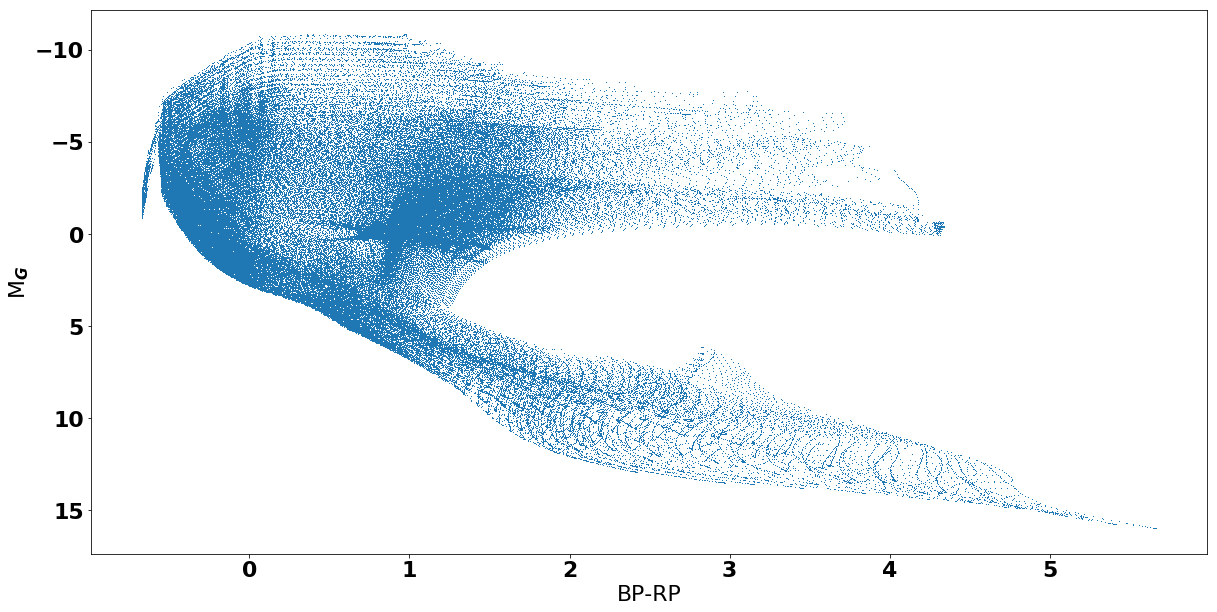

<Figure size 432x288 with 0 Axes>

In [5]:
# First we load the parsec Isochrones from day 1.
p = np.load('../data/day_1/parsec_isochrones/no_ext_grid.npy')
p = p.view(np.recarray)
p.teff = 10**p.teff
p.lum = 10**p.lum
print(len(p),p.dtype.names)
plt.figure(figsize=(20,10))
plt.plot(p.gaia_bp-p.gaia_rp,p.gaia_g,',')
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel(r'M$_{G}$')
plt.show()
plt.clf()

# Task 2
#### Build a simple forward model f(m,&tau;,feh) --> {M<sub>G</sub>,BP-RP} using the parsec grid
#### Hints:
- The simplest model would just be to look for the nearest parsec star that has the mass, age and feh from the input
- You can find its index very efficiently by using a k-dimensional tree.
- Initialize the index structure using:
```python
parsec_index = cKDTree(np.c_[p.mass,p.age,p.feh])
```
- Check what np.c_ is actually doing.
- The index which is closest to specific values can now be queried via:
```python
index = parsec_index.query(np.c_[mass,age,feh])[1]
```
- Try this for mass = 1, age = 4.5 and feh = 0 and check whether the retrieved star (```p[index]```) is similar to the sun.
- Now you can wrap this in a function such that it returns M<sub>G</sub> and BP-RP.
- Because the creation of the parsec index takes a long time, try to only do it once (outside the function, then hand it over as an argument).

In [6]:
# They have all observables and stellar parameters that we need. From that we can build a simple forward model
# forward model: input is mass age and metallicity (we neglect extinction)
parsec_index = cKDTree(np.c_[p.mass,p.age,p.feh])
# simple forward model
def ap2obs(parsec,index,mass,age,feh):
    '''
    parsec = the parsec models as a recarray
    index = the k-d tree
    mass = mass of the star in Msun
    age = age of the star in Gyr
    feh = metallicity in dex
    
    returns M_G and BP-RP for the nearest model star in the parsec grid
    '''
    if mass < 0.09 or mass > 67.1414032:
        return(-np.inf,-np.inf)
    elif age < 3.98107171e-03 or age > 1.12201845e+01:
        return(-np.inf,-np.inf)
    elif feh < -2 or feh > 0.5:
        return(-np.inf,-np.inf)
    else:
        cut = index.query(np.c_[mass,age,feh])[1]
        bpmrp = parsec[cut].gaia_bp - parsec[cut].gaia_rp
        abs_g = parsec[cut].gaia_g
        return(abs_g,bpmrp)
# If we want to make more sophisticated forward model (with averaging between nearby points) we need to rescale the variables.
# We could also interpolate a finer grid...

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


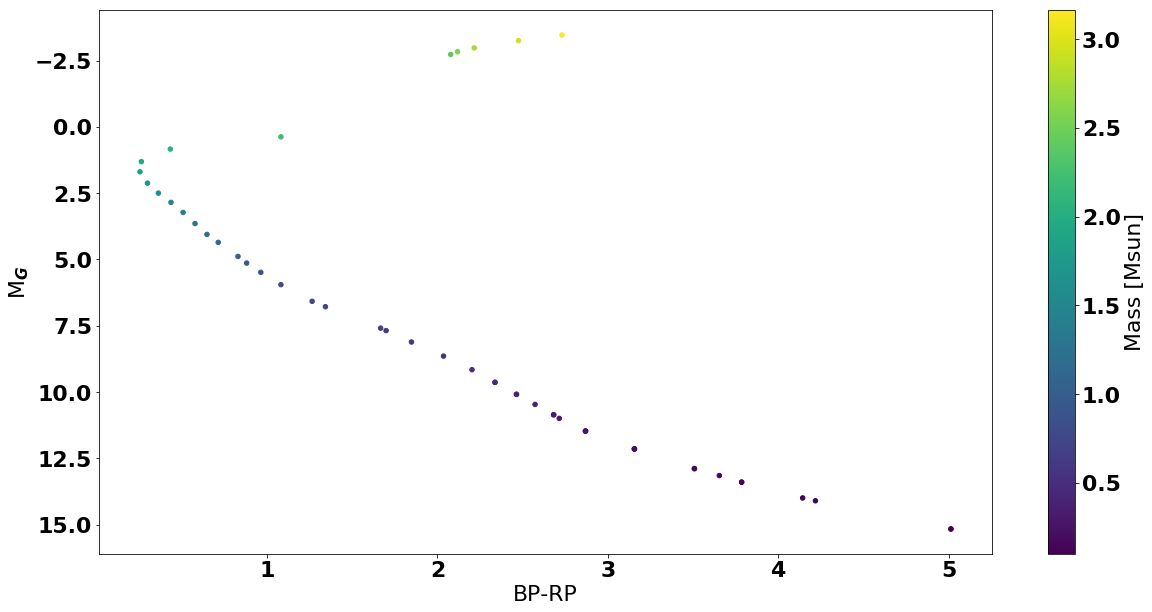

<Figure size 432x288 with 0 Axes>

In [7]:
# We plot a sequence in mass

masses = np.logspace(-1,0.5,50)
color = np.zeros_like(masses)
abs_g = np.zeros_like(masses)
for i,mass in enumerate(masses):
    age = 1
    feh = 0
    abs_g[i], color[i] = ap2obs(p,parsec_index,mass,age,feh)
plt.figure(figsize=(20,10))
plt.scatter(color,abs_g,s=20,c=masses)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel(r'M$_{G}$')
plt.colorbar(label = 'Mass [Msun]')
plt.show()
plt.clf()

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


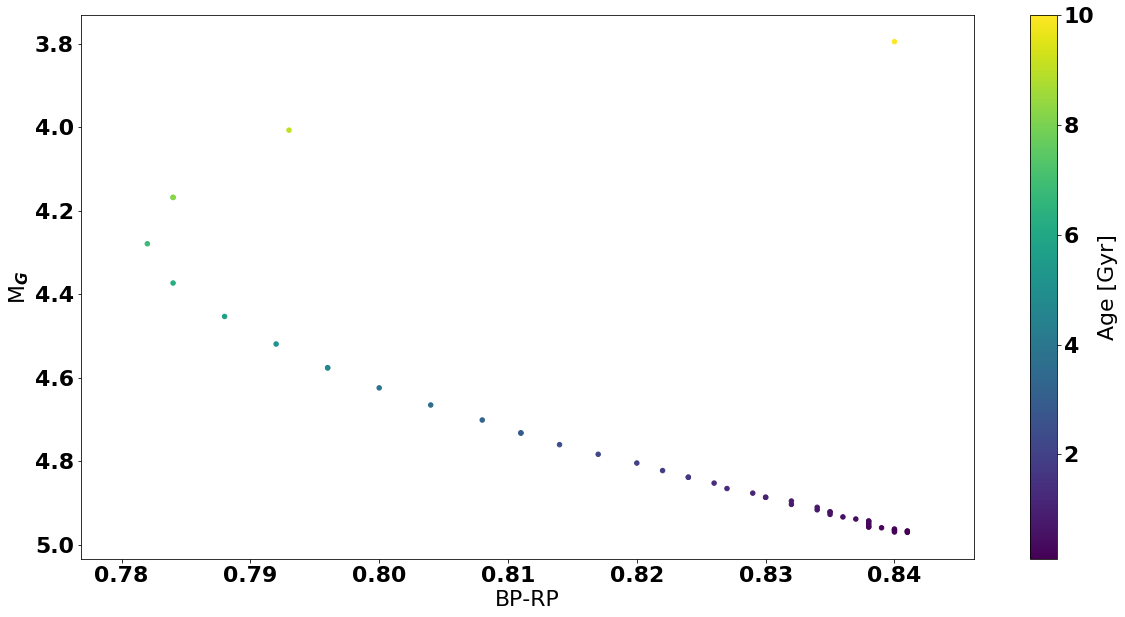

<Figure size 432x288 with 0 Axes>

In [8]:
# And a sequence in age

ages = np.logspace(-1,1,50)
color = np.zeros_like(ages)
abs_g = np.zeros_like(ages)
for i,age in enumerate(ages):
    mass = 1
    feh = 0
    abs_g[i], color[i] = ap2obs(p,parsec_index,mass,age,feh)
plt.figure(figsize=(20,10))
plt.scatter(color,abs_g,s=20,c=ages)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel(r'M$_{G}$')
plt.colorbar(label = 'Age [Gyr]')
plt.show()
plt.clf()

In [9]:
# Now we want to build a prior for the close encounter sample
model = np.load('../data/temp/mock_data.npy')
model = model.view(np.recarray)
print(len(model), model.dtype.names)

2694 ('source_id', 'ra', 'dec', 'ra_error', 'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_bp_excess_factor', 'radial_velocity', 'radial_velocity_error', 'astrometric_gof_al', 'astrometric_params_solved', 'random_index', 'l', 'b', 'phot_g_n_obs', 'phot_variable_flag', 'phot_rp_n_obs', 'phot_bp_n_obs', 'bp_rp', 'bp_g', 'g_rp', 'phot_rvs_mean_mag', 'rv_nb_transits', 'ref_epoch', 'astrometric_delta_q', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_n_obs_ac', 'astrometric_n_obs_al', 'astrometric_n_bad_obs_ac', 'astrometric_n_bad_obs_al', 'astrometric_n_good_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_chi2_al', 'astrometric_primary_flag', 'astrometric_pseudo_colour', 'mean_varpi_factor_al', 'visiblilty_periods

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


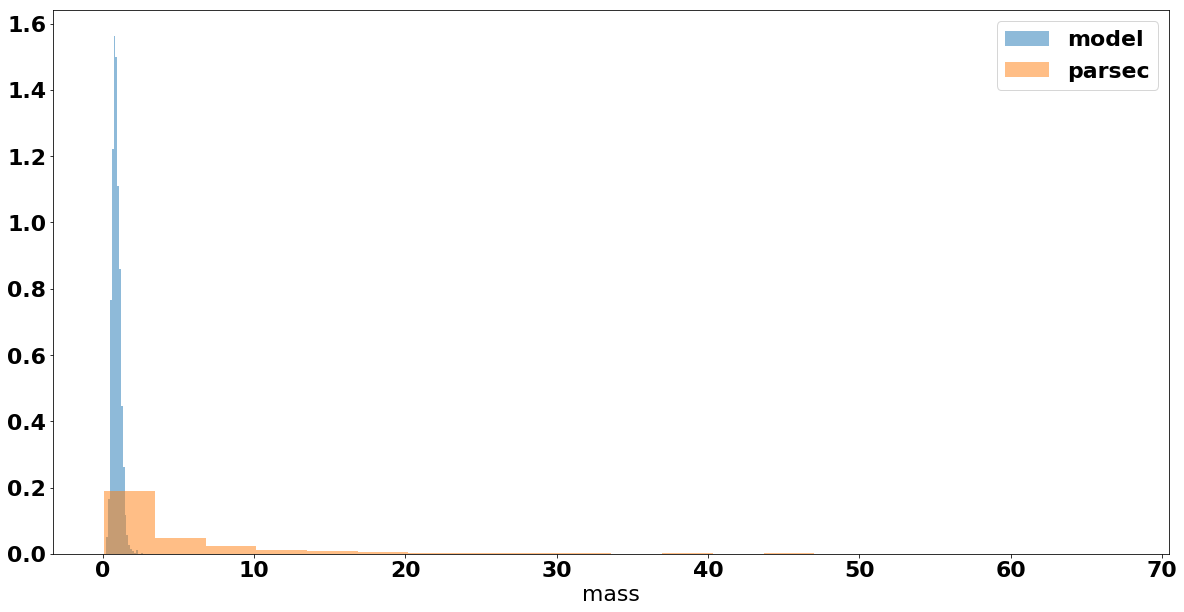

<Figure size 432x288 with 0 Axes>

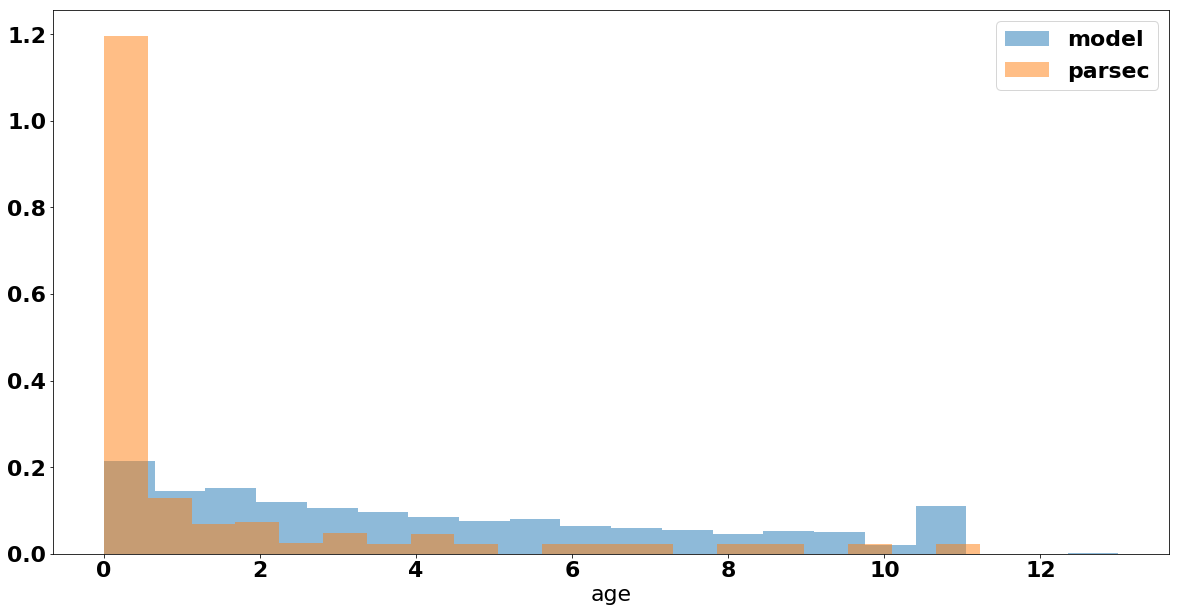

<Figure size 432x288 with 0 Axes>

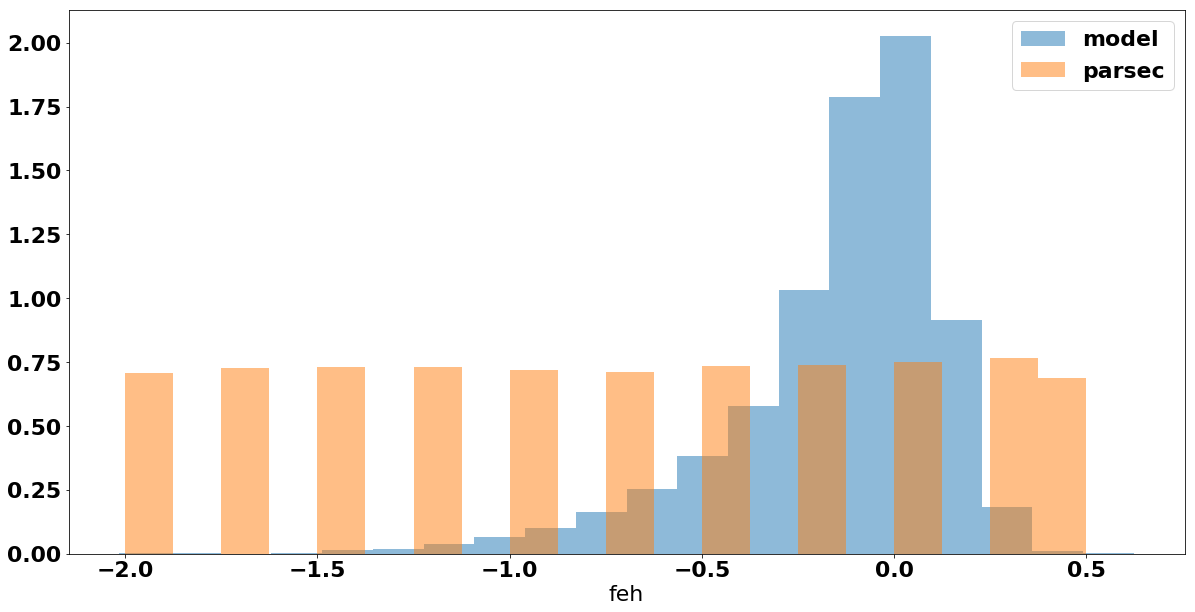

<Figure size 432x288 with 0 Axes>

In [10]:
# Lets see how the mock data compare to the parsec distribution

for item in ['mass','age','feh']:
    plt.figure(figsize=(20,10))
    plt.hist(model[item],20,alpha =0.5, label = 'model', density=True)
    plt.hist(p[item],20,alpha =0.5,label = 'parsec', density=True)
    plt.xlabel(item)
    plt.legend()
    plt.show()
    plt.clf()


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


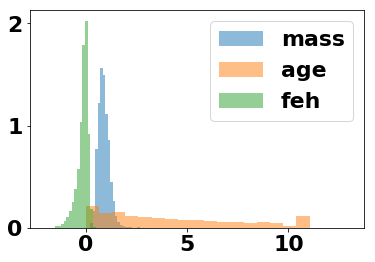

In [11]:
# getting the density at specific grid points
vmass,r,__ = plt.hist(model['mass'],20,alpha =0.5, label = 'mass', density=True)
# taking the average of two adjacend grid points
rmass = np.divide(r[:-1]+r[1:],2)
# same for age
vage,r,__ = plt.hist(model['age'],20,alpha =0.5, label = 'age', density=True)
rage = np.divide(r[:-1]+r[1:],2)
# same for feh
vfeh,r,__ = plt.hist(model['feh'],20,alpha =0.5, label = 'feh', density=True)
# taking the average of two adjacend grid points
rfeh = np.divide(r[:-1]+r[1:],2)
plt.legend()

In [12]:
def prior(mass,age,feh, rmass,vmass,rage,vage,rfeh,vfeh):
    pmass = np.interp(mass,rmass,vmass)
    page = np.interp(age,rage,vage)
    pfeh = np.interp(feh,rfeh,vfeh)
    return(np.log(pmass * page * pfeh))


1995
450
371


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


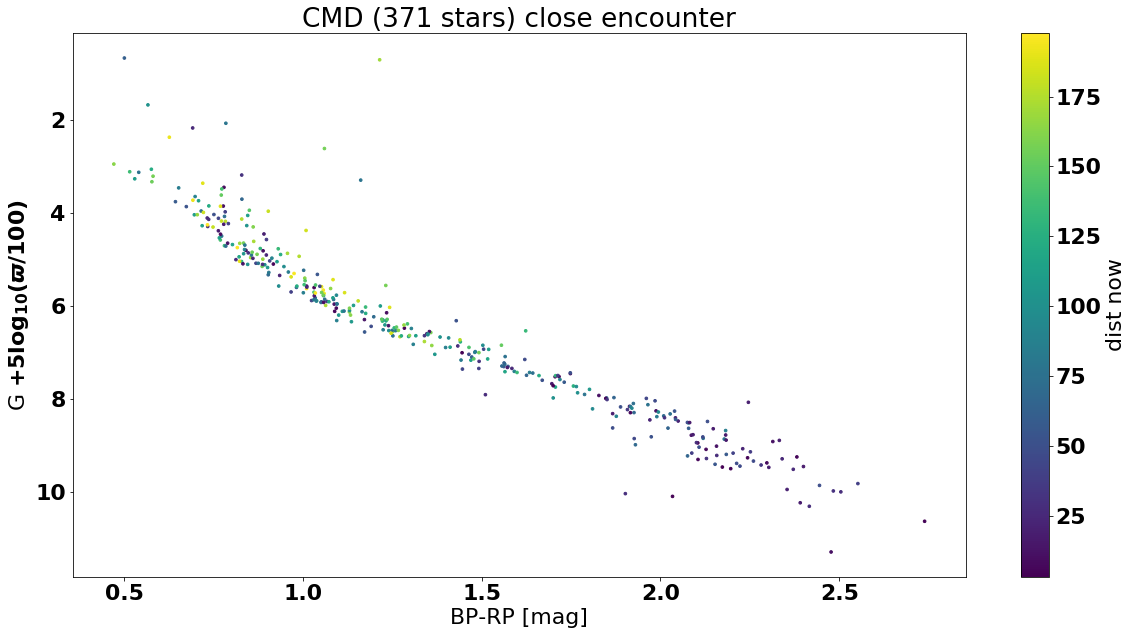

In [13]:
# Look at closest encounters
data = np.load('../data/temp/data.npy')
data = append_fields(data,['mass16','mass','mass84','age16','age','age84','feh16','feh','feh84','lnprob16','lnprob','lnprob84','acceptfrac','autocorr'],(np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data)),np.zeros(len(data))),usemask = False, asrecarray = True)
print(len(data))
data = data[(data.orbit_min_distance<5)]
print(len(data))
data = data[(1000/data.parallax<200)]
print(len(data))
plot_hrd(data, 'close encounter', np.divide(1000,data.parallax), 'dist now')

/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


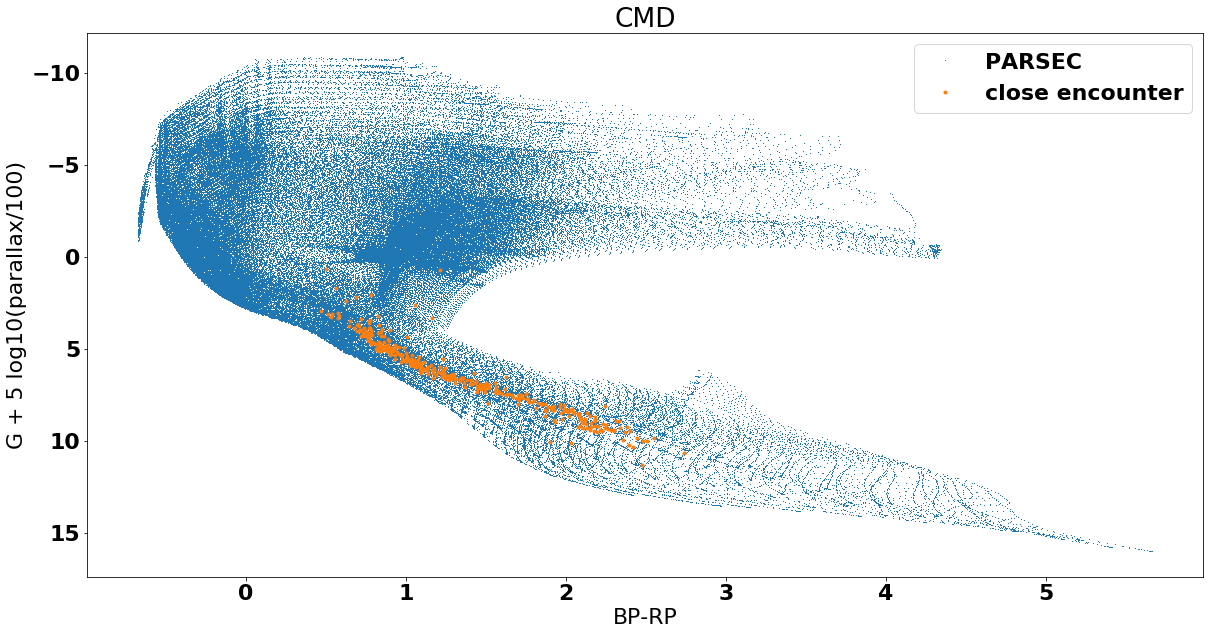

In [14]:
# And plot it versus the parsec models
mcolor = p.gaia_bp - p.gaia_rp
mabs_mag = p.gaia_g
dcolor = data.phot_bp_mean_mag - data.phot_rp_mean_mag
dabs_mag = data.phot_g_mean_mag + 5 * np.log10(np.divide(data.parallax,100))
plt.figure(figsize=(20,10))
plt.plot(mcolor,mabs_mag,',',label = "PARSEC")
plt.plot(dcolor,dabs_mag,'.', label = 'close encounter')
plt.gca().invert_yaxis()
plt.ylabel("G + 5 log10(parallax/100)")
plt.xlabel("BP-RP")
plt.title("CMD")
plt.legend()

In [15]:
gliese = data[(data.orbit_min_distance==min(data.orbit_min_distance))]

In [16]:
# Once again error analysis
print('parallax','parallax_error','phot_g_mean_mag','phot_g_mean_mag_error')
print(gliese[['parallax','parallax_error','phot_g_mean_mag','phot_g_mean_mag_error']])

parallax parallax_error phot_g_mean_mag phot_g_mean_mag_error
[(52.5475, 0.0478, 9.0608, 0.0005)]


In [17]:
# Direct calculation
print('error propagation for M_G')
abs_g = gliese.phot_g_mean_mag + 5 * np.log10(np.divide(gliese.parallax,100))
print('no error: ',abs_g)
# Propagate error in parallax
abs_g = gliese.phot_g_mean_mag + 5 * np.log10(np.divide(np.random.normal(gliese.parallax,gliese.parallax_error,1000),100))
print('error in parallax: ',np.mean(abs_g),np.std(abs_g))
# propagate error in gmag
abs_g = np.random.normal(gliese.phot_g_mean_mag,gliese.phot_g_mean_mag_error,1000) + 5 * np.log10(np.divide(gliese.parallax,100))
print('error in gmag: ',np.mean(abs_g),np.std(abs_g))
#propagate both errors
abs_g = np.random.normal(gliese.phot_g_mean_mag,gliese.phot_g_mean_mag_error,1000) + 5 * np.log10(np.divide(np.random.normal(gliese.parallax,gliese.parallax_error,1000),100))
print('propagating both error: ',np.mean(abs_g),np.std(abs_g))

error propagation for M_G
no error:  [7.66355989]
error in parallax:  7.6635793444343 0.0019339010295323948
error in gmag:  7.663536738879244 0.0004843472798008438
propagating both error:  7.663605210413985 0.0019790438350053433


In [18]:
# BPRP error
print('error propagation in bprp')
c = gliese.phot_bp_mean_mag - gliese.phot_rp_mean_mag
print('no error: ',c)
# both errors error
c = np.random.normal(gliese.phot_bp_mean_mag,gliese.phot_bp_mean_mag_error,1000) - np.random.normal(gliese.phot_rp_mean_mag,gliese.phot_rp_mean_mag_error,1000)
print('both errors: ',np.mean(c),np.std(c))

error propagation in bprp
no error:  [1.6960001]
both errors:  1.6960518431876677 0.0033399714736360945


In [19]:
def get_error(data_item):
    #propagate both errors
    abs_g = np.random.normal(data_item.phot_g_mean_mag,data_item.phot_g_mean_mag_error,1000) + 5 * np.log10(np.divide(np.random.normal(data_item.parallax,data_item.parallax_error,1000),100))
    gd = np.mean(abs_g)
    ge = np.std(abs_g) 
    # BPRP error
    c = np.random.normal(data_item.phot_bp_mean_mag,data_item.phot_bp_mean_mag_error,1000) - np.random.normal(data_item.phot_rp_mean_mag,data_item.phot_rp_mean_mag_error,1000)
    cd = np.mean(c)
    ce = np.std(c)
    return(cd,ce,gd,ge)
get_error(gliese)

(1.6960411117669931,
 0.003220941586068032,
 7.663675953590942,
 0.0021064875983077096)

In [20]:
# We have to define a log likelihood it measures how well the model fits the data (just multiplication of 2 Gaussians)
def lnlikelihood(g_model,g_data,g_error,c_model,c_data,c_error):
    '''
    this is an unnormalised ln likelihood function
    '''
    g_like = -1*((g_model - g_data)**2)/(2*g_error**2)
    c_like = -1*((c_model - c_data)**2)/(2*c_error**2)
    return(g_like + c_like) 

In [21]:
def lnprob(x, ivar):
    cd,ce,gd,ge = ivar
    mass,age,feh = x
    gm,cm = ap2obs(p,parsec_index,mass,age,feh)
    lnlike = lnlikelihood(gm,gd,ge,cm,cd,ce)
    lnprior = prior(mass,age,feh, rmass,vmass,rage,vage,rfeh,vfeh)
    if np.isnan(lnlike):
        lnlike = -np.inf
    return(lnlike + lnprior)

In [22]:
ndim, nwalkers = 3, 6
ivar = get_error(gliese)
p0_ind = np.random.choice(len(p),replace = False, size = nwalkers)
p0= np.c_[p[p0_ind]['mass'],p[p0_ind]['age'],p[p0_ind]['feh']]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
pos, prob, state = sampler.run_mcmc(p0, 2000)

sampler.reset()
sampler.run_mcmc(pos, 100)
print("Mean acceptance fraction: {0:.3f}".format(np.median(sampler.acceptance_fraction)),
      "lnprob: {0:.3f}".format(np.median(sampler.flatlnprobability)),
      "mass: {0:.3f}".format(np.median(sampler.flatchain[:,0])))
for i, item in enumerate(['mass','age','feh']):
    gliese[item] = np.median(sampler.flatchain[:,i])
    gliese[item + '16'] = np.percentile(sampler.flatchain[:,i],16)
    gliese[item + '84'] = np.percentile(sampler.flatchain[:,i],84)
gliese['lnprob'] = np.median(sampler.flatlnprobability)
gliese['lnprob16'] = np.percentile(sampler.flatlnprobability,16)
gliese['lnprob84'] = np.percentile(sampler.flatlnprobability,84)
gliese['acceptfrac'] = np.median(sampler.acceptance_fraction)

/home/rybizki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Mean acceptance fraction: 0.250 lnprob: -343.082 mass: 0.614


In [23]:
for item in ['mass','age','feh','lnprob']:
    print(item, gliese[item + '16'], gliese[item], gliese[item + '84'])
p[parsec_index.query(np.c_[gliese.mass, gliese.age, gliese.feh])[1]]

mass [0.59887737] [0.6141617] [5.14387954]
age [0.01572551] [2.50906402] [6.33273644]
feh [-1.38271355] [-0.19359811] [0.39482964]
lnprob [-8560231.05198018] [-343.08199113] [-342.66759428]


rec.array([(0.60000002, 2.51188643, -0.25, 0., 4169.65382245, 4.686, 0.09170647, 7.668, 8.445, 6.833, 10.785, 9.52, 8.253, 7.377, 6.682, 5.82, 5.147, 5.008, 11.618, 8.949, 7.707, 7.221, 6.957, 5.769, 5.118, 4.977, 4.887, 4.897, 4.785, 4.763)],
          dtype=[('mass', '<f8'), ('age', '<f8'), ('feh', '<f8'), ('a0', '<f8'), ('teff', '<f8'), ('logg', '<f8'), ('lum', '<f8'), ('gaia_g', '<f8'), ('gaia_bp', '<f8'), ('gaia_rp', '<f8'), ('ubv_u', '<f8'), ('ubv_b', '<f8'), ('ubv_v', '<f8'), ('ubv_r', '<f8'), ('ubv_i', '<f8'), ('ubv_j', '<f8'), ('ubv_h', '<f8'), ('ubv_k', '<f8'), ('sdss_u', '<f8'), ('sdss_g', '<f8'), ('sdss_r', '<f8'), ('sdss_i', '<f8'), ('sdss_z', '<f8'), ('2mass_j', '<f8'), ('2mass_h', '<f8'), ('2mass_ks', '<f8'), ('wise_w1', '<f8'), ('wise_w2', '<f8'), ('wise_w3', '<f8'), ('wise_w4', '<f8')])

In [24]:
'''
ndim, nwalkers = 3, 6
for s in range(len(data)):
    
    # preparing the measurement and error
    ivar = get_error(data[s])
    
    # initializing the walkers (this could be imporved by not randomly initializing)
    p0_ind = np.random.choice(len(p),replace = False, size = nwalkers)
    p0= np.c_[p[p0_ind]['mass'],p[p0_ind]['age'],p[p0_ind]['feh']]

    # The MCMC is started and run for 2000 steps
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
    pos, prob, state = sampler.run_mcmc(p0, 2000)
    
    # Then the burn in is thrown away and we sample 100 more times for the result
    sampler.reset()
    sampler.run_mcmc(pos, 100)
    print(s,"Mean acceptance fraction: {0:.3f}".format(np.median(sampler.acceptance_fraction)),
          "lnprob: {0:.3f}".format(np.median(sampler.flatlnprobability)),
          "mass: {0:.3f}".format(np.median(sampler.flatchain[:,0])))
    # We save summary statistics of the MCMC chain
    for i, item in enumerate(['mass','age','feh']):
        data[s][item] = np.median(sampler.flatchain[:,i])
        data[s][item + '16'] = np.percentile(sampler.flatchain[:,i],16)
        data[s][item + '84'] = np.percentile(sampler.flatchain[:,i],84)
    data[s]['lnprob'] = np.median(sampler.flatlnprobability)
    data[s]['lnprob16'] = np.percentile(sampler.flatlnprobability,16)
    data[s]['lnprob84'] = np.percentile(sampler.flatlnprobability,84)
    data[s]['acceptfrac'] = np.median(sampler.acceptance_fraction)
np.save('../data/temp/mcmc_data.npy',data)
'''

'\nndim, nwalkers = 3, 6\nfor s in range(len(data)):\n    \n    # preparing the measurement and error\n    ivar = get_error(data[s])\n    \n    # initializing the walkers (this could be imporved by not randomly initializing)\n    p0_ind = np.random.choice(len(p),replace = False, size = nwalkers)\n    p0= np.c_[p[p0_ind][\'mass\'],p[p0_ind][\'age\'],p[p0_ind][\'feh\']]\n\n    # The MCMC is started and run for 2000 steps\n    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])\n    pos, prob, state = sampler.run_mcmc(p0, 2000)\n    \n    # Then the burn in is thrown away and we sample 100 more times for the result\n    sampler.reset()\n    sampler.run_mcmc(pos, 100)\n    print(s,"Mean acceptance fraction: {0:.3f}".format(np.median(sampler.acceptance_fraction)),\n          "lnprob: {0:.3f}".format(np.median(sampler.flatlnprobability)),\n          "mass: {0:.3f}".format(np.median(sampler.flatchain[:,0])))\n    # We save summary statistics of the MCMC chain\n    for i, item

In [25]:
# Quality indicators of the convergence
print('lnprob: ',np.percentile(data.lnprob,[5,34,50,86,95]))
print('acceptance fraction: ',np.percentile(data.acceptfrac,[5,34,50,86,95]))

lnprob:  [0. 0. 0. 0. 0.]
acceptance fraction:  [0. 0. 0. 0. 0.]


371
191


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


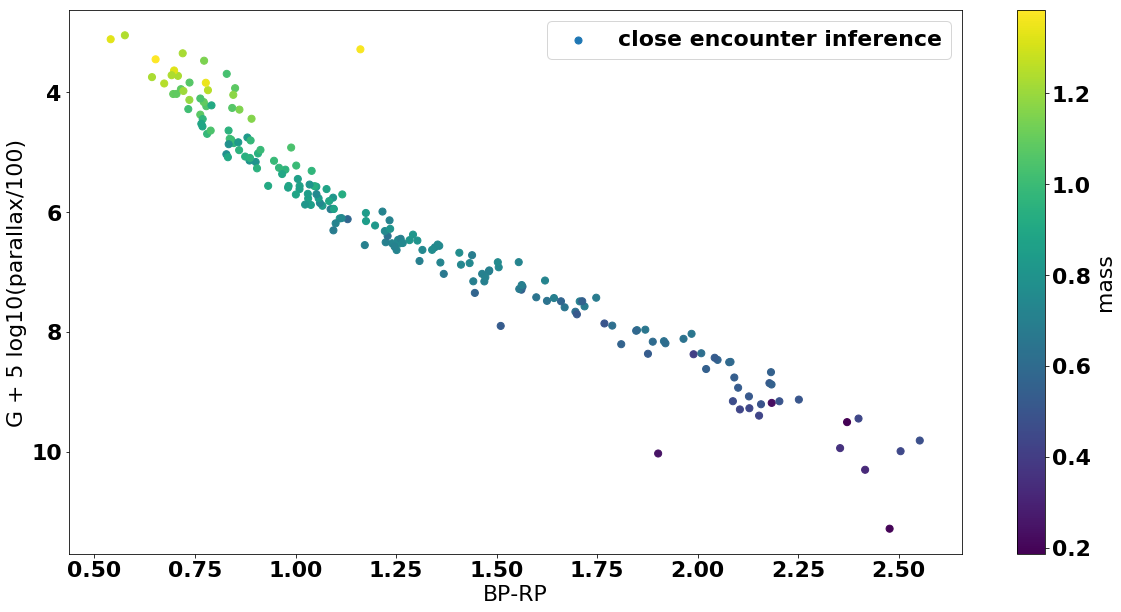

<Figure size 432x288 with 0 Axes>

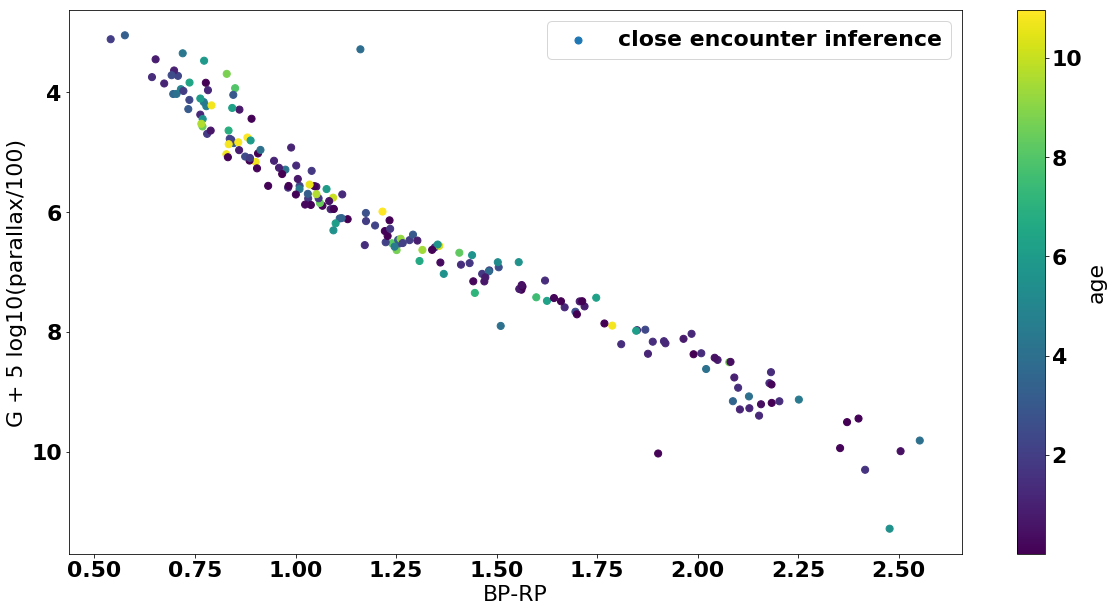

<Figure size 432x288 with 0 Axes>

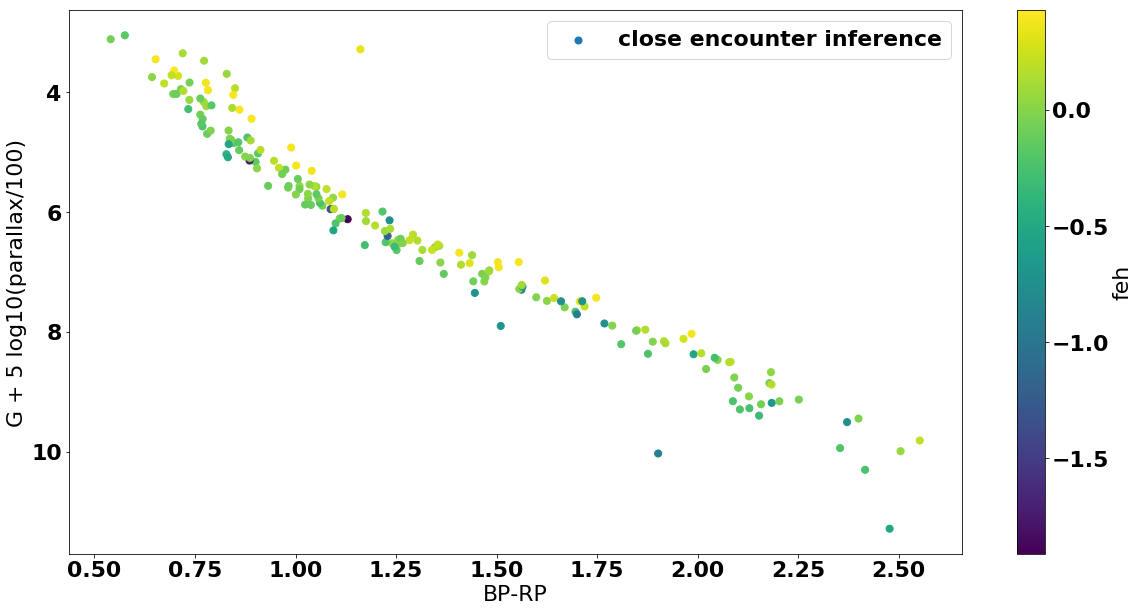

<Figure size 432x288 with 0 Axes>

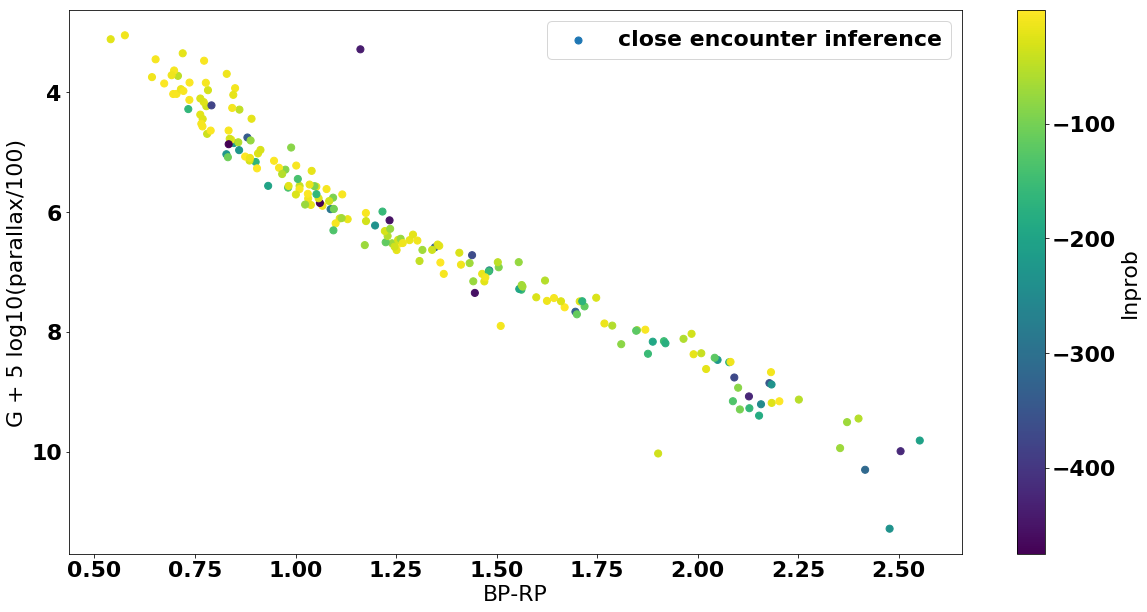

<Figure size 432x288 with 0 Axes>

In [26]:
data = np.load('../data/temp/mcmc_data.npy')
data = data.view(np.recarray)
# And plot the result


convergence_cut = (data.lnprob>-500) & (data.acceptfrac > 0.1)
print(len(data))
data=data[convergence_cut]
print(len(data))
for item in ['mass','age','feh','lnprob']:
    plt.figure(figsize=(20,10))
    im = plt.scatter(data.phot_bp_mean_mag-data.phot_rp_mean_mag,
                     data.phot_g_mean_mag + 5*np.log10(np.divide(data.parallax,100)), label = 'close encounter inference',
                     s=50,c=data[item])#, vmin = 0, vmax = 2)
    plt.gca().invert_yaxis()
    plt.colorbar(im, label = item)
    plt.ylabel("G + 5 log10(parallax/100)")
    plt.xlabel("BP-RP")
    plt.legend()
    plt.show()
    plt.clf()


/home/rybizki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


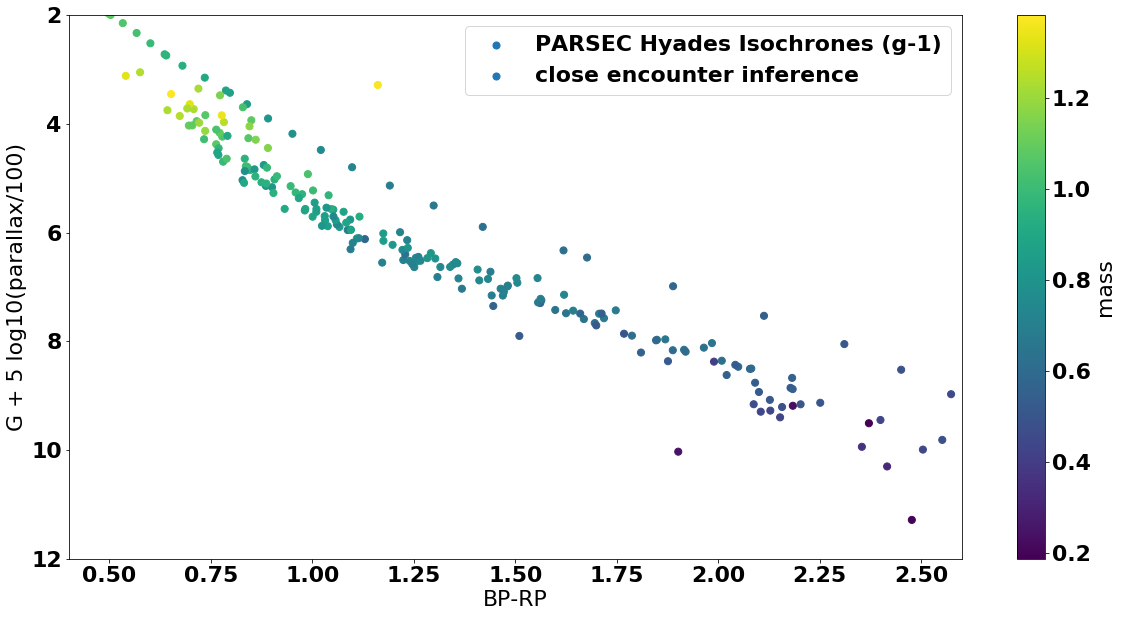

<Figure size 432x288 with 0 Axes>

In [27]:
color = p.gaia_bp - p.gaia_rp
abs_mag = p.gaia_g
age_values = np.unique(p.age)
cut = np.where(np.logical_and(p.feh == 0.25,p.age == age_values[43]))

plt.figure(figsize=(20,10))
im = plt.scatter(color[cut],abs_mag[cut]-1,s=50,c=p.mass[cut], vmin = 0, vmax = 2, label = "PARSEC Hyades Isochrones (g-1)" )
im = plt.scatter(data.phot_bp_mean_mag-data.phot_rp_mean_mag,
                 data.phot_g_mean_mag + 5*np.log10(np.divide(data.parallax,100)), label = 'close encounter inference',
                 s=50,c=data.mass)#, vmin = 0, vmax = 2)
plt.gca().invert_yaxis()
plt.colorbar(im, label = 'mass')
plt.xlim((0.4,2.6))
plt.ylim((12,2))
plt.ylabel("G + 5 log10(parallax/100)")
plt.xlabel("BP-RP")
plt.legend()
plt.show()
plt.clf()

In [28]:
for item in data:
    print('##########################')
    for name in ['mass','age','feh']:
        print(name,item[name + '16'],item[name], item[name + '84'])

##########################
mass 0.7078113048376715 0.7318653378210556 0.7566408653314528
age 0.052384443805968676 1.5786304700314235 1.9695464523575017
feh -0.13187256272144954 0.02529424853925294 0.133703841258836
##########################
mass 0.7951363032512515 0.8720748568673694 0.9364272270942388
age 1.6716362540881295 2.331731195298434 3.028996331653365
feh -0.49645537672864304 0.055203366522052655 0.37977740215771383
##########################
mass 0.8347618397617094 0.8589112341594078 2.522914408791432
age 0.49895084055802397 0.6656151862831925 0.9457330295600657
feh -0.16469755567597535 0.03926140070897721 0.37545256772055235
##########################
mass 1.242372116512187 1.253484479067006 4.612212952952141
age 0.15038428546534366 1.2713460990500738 1.3062509328242766
feh -1.8739541416473124 0.3870793203463292 0.39679080858921023
##########################
mass 0.6522562947220008 0.8547605615223746 0.8767073607789754
age 0.016612440408191403 4.437735329719494 8.54200538803

mass 0.6397358773522223 0.6881417262090108 8.294571903216974
age 0.006466541914754154 1.0386276651553503 10.787509797157677
feh -1.798753338607035 -1.3422664522652632 -1.1515770601697988
##########################
mass 0.5937580430586515 0.7016748892447678 0.7284645625457813
age 0.013742550863657499 9.174063177523278 10.202378301810493
feh -1.612109038620945 -0.0971294524693782 0.07996900000731874
##########################
mass 0.5300190189477144 0.6172866252893098 0.6267660910402504
age 0.1606490240927525 1.4072081255354034 2.3807169248985804
feh 0.04753912455459193 0.18057085162082762 0.3629298371465696
##########################
mass 1.106850531325939 1.1518395110232438 1.1654506159462905
age 0.6860042122046228 0.724928968730435 1.208334523728546
feh 0.1315337588092773 0.38737465248166586 0.3964668093953728
##########################
mass 0.4964866192991847 0.5003539836998493 0.5726566731292907
age 0.0230841984132606 0.031136069202501716 0.4258007590527779
feh -0.8280711305463673 -

In [29]:
# Calculate impact (impuls by star depends on speed and mass), grav. redshift (correct for it with the mass and recalculate orbits)